# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [2]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [3]:
data = pd.read_csv('train.csv')

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [6]:
train.isnull().any() # есть пропуски keyword и location
test.isnull().any()  # аналогично

# заполнили пропуски 
train.fillna('', inplace=True)
test.fillna('', inplace=True)

# теперь все хорошо
train.isnull().any().any() # False 
test.isnull().any().any()  # False 

False

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [7]:
# train.target.unique() - убедились, что класса всего два [0, 1]
total_count = train.shape[0]
false_count = (train.target == 0).sum()
print(f"Класс 0: {round(100 * false_count/total_count, 2)}%")
print(f"Класс 1: {100 - round(100 * false_count/total_count, 2)}%")

Класс 0: 56.75%
Класс 1: 43.25%


2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [8]:
popular_keywords = np.array(train.keyword.value_counts()[1:11].index) # самое популярное - пустое значение, его пропустили

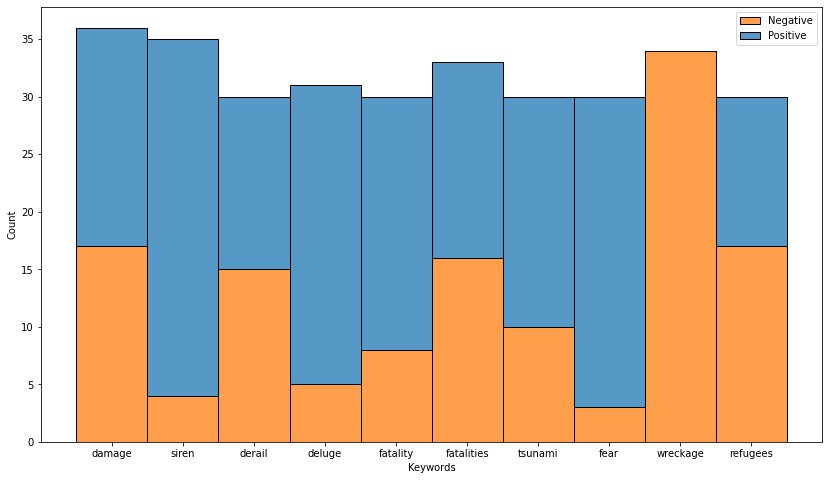

In [35]:
plt.subplots(figsize=(14,8))
sns.histplot(data=train[train.keyword.isin(popular_keywords)], x="keyword", hue="target", multiple="stack")
plt.xlabel("Keywords")
plt.ylabel("Count")
plt.legend(["Negative", "Positive"])
plt.show()

**Выводы**: 
Целевая переменная очень хорошо перемешана между различными ключевыми словами, так что по ним не удастся провести классификацию. Исключениями являются лишь некоторые слова, но они покрывают очень маленькую часть датасета, чтобы предсказывать что-то.

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [10]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [11]:
train_new = train.copy()
train_new['text'] = train[['keyword', 'location', 'text']].agg(' '.join, axis=1)

train_new.drop(columns=["id", "keyword", "location"], inplace=True)

test_new = test.copy()
test_new['text'] = test[['keyword', 'location', 'text']].agg(' '.join, axis=1)

test_new.drop(columns=["id", "keyword", "location"], inplace=True)

In [12]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer()
matrix = cnt_vec.fit_transform(train_new.text)
matrix.shape # очень много слов

(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [14]:
def contains_digit(s: str) -> bool:
    return any(l.isdigit() for l in s)

def contains_punctuation(s: str) -> bool:
    punc = '''!()-[]{};:'"\\,<>./?$%^&@#*_~`'''
    for l in s:
        if l in punc:
            return True 
    return False 

def is_hashtag(s: str) -> bool:
    return s[0] == "#"

def is_mention(s: str) -> bool:
    return s[0] == "@" and s[1:].isalnum()

def investigate_vocabulary(vocabulary):
    counts = {l: 0 for l in "dphm" }
    for word in vocabulary:
        counts["d"] += contains_digit(word)
        counts["p"] += contains_punctuation(word)
        counts["h"] += is_hashtag(word)
        counts["m"] += is_mention(word)
    
    print('With digit:      ', counts["d"]
          )
    print('With punctuation:', counts["p"]
          )
    print('Hashtags:        ', counts["h"]
          )
    print('Mentions:        ', counts["m"]
          )




In [15]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [16]:
investigate_vocabulary( cnt_vec.vocabulary_
                       )

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [17]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer
tknzr = TweetTokenizer()
texts = texts_tokenized = [
    " ".join([w for w in tknzr.tokenize(t) if w.isalpha()]) for t in train_new.text
]


In [18]:
cnt_vec = CountVectorizer() 
matrix = cnt_vec.fit_transform(texts)
matrix.shape # на треть меньше

(5329, 11702)

In [19]:
investigate_vocabulary(cnt_vec.vocabulary_
                       )

With digit:       0
With punctuation: 0
Hashtags:         0
Mentions:         0


**Сравнение:** 
Мы уменьшили размеры массива векторов слов и избавились от лишних символов, которые не несут смысловой нагрузки для нашей задачи. Размер массива уменьшился приблизительно на треть, но есть слова, которые повторяются в разных формах.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [20]:
import re 
import nltk
nltk.download('stopwords')
import nltk.corpus as corpus
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
tknzr = TweetTokenizer()
stopwords = corpus.stopwords.words('english')
punc = '''!()-[]{};:'"\\,<>|./?$%^&@#*_~`'''

def contains_only_latin_letters(s: str) -> bool:
    return bool(re.match(r'^[a-zA-Z]+$', s))

def is_emoji(s: str) -> bool:
    b = "(){}[]"
    return all(l in punc for l in s) and any(l in b for l in s)

def is_hashtag(s: str) -> bool:
    return s[0] == '#' and s[1:].isalpha()

def custom_tokenizer(s: str) -> List[str]:  
    arr = tknzr.tokenize(s)  
    res = []
    for word in arr:
        if is_emoji(word):
            res.append(word)
            continue
        if is_hashtag(word):
            res.append(word.lower())
            continue
        word = stemmer.stem(word.lower())
        if not contains_only_latin_letters(word):
            continue
        if not word in stopwords:
            res.append(word)
    return res

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TechnoDX\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [22]:
print(*map(custom_tokenizer, train_new[:10].text), sep="\n")

['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblue', '#wrestleon']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'dure', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
['airplan', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
['burn', 'except', 'idk', 'realli', 'burn']
['destroy', '(', 'ask', ')', 'destroy', 'hous']
['wound', 'maracay', 'nirgua', 'venezuela', 'polic', 'offic', 'wound',

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [23]:
from sklearn.preprocessing import MaxAbsScaler
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None
                             )
def process(train, test, vectorizer):
    train_X = vectorizer.fit_transform(train.text) 
    test_X = vectorizer.transform(test.text) 
    train_y = train_new.target
    test_y = test_new.target

    scaler = MaxAbsScaler()
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.transform(test_X)
    return train_X, train_y, test_X, test_y 

train_X, train_y, test_X, test_y = process(train_new, test_new, vectorizer)


2. Обучите LogisticRegression на полученных признаках.


In [24]:
from sklearn.linear_model import LogisticRegression


regression = LogisticRegression(max_iter=1000, random_state=42)
regression.fit(train_X, train_y);

3. Посчитайте метрику f1-score на тестовых данных.

In [25]:
from sklearn.metrics import f1_score

print("F1 score:", np.round(f1_score(test_y, regression.predict(test_X)), 4))

F1 score: 0.7472


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    tokenizer=custom_tokenizer,
)

train_X, train_y, test_X, test_y = process(train_new, test_new, vectorizer)

regressionTI = LogisticRegression(max_iter=1000, random_state=42)
regressionTI.fit(train_X, train_y)

print("F1 score:", np.round(f1_score(test_y, regressionTI.predict(test_X)), 4))

c:\Users\TechnoDX\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7446


1. **Ответ:** Качество немного упало. Возможно используется много редких слов и почти всегда встречаются одинаковые слова, что делает их веса приблизительно одинаковыми и не несет ценности для линейной регрессии.

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [27]:
vectorizer = TfidfVectorizer(
    tokenizer=custom_tokenizer,
    max_df=0.9
)
print("Количество до:", train_X.count_nonzero())
train_X, train_y, test_X, test_y = process(train_new, test_new, vectorizer)
print("Количество после:", train_X.count_nonzero())


Количество до: 51692


c:\Users\TechnoDX\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Количество после: 51692


In [28]:
regressionTI = LogisticRegression(max_iter=1000, random_state=42)
regressionTI.fit(train_X, train_y)

print("F1 score:", np.round(f1_score(test_y, regressionTI.predict(test_X)), 4))

F1 score: 0.7446


2. **Ответ:** Значения df были порядка 0.01, так что добавление верхней границы не изменило число слов. Зато если поставить max_df = 0.01, то все будет хорошо и размер матрицы упадет от 51692 элементов до 40001 элемента, то есть где-то на 23%. F1 score при этом упадет до 70%, что не очень хорошо

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [29]:
vectorizer = TfidfVectorizer(
    tokenizer=custom_tokenizer,
    min_df=0.001
)
print("Количество до:", train_X.count_nonzero())
train_X, train_y, test_X, test_y = process(train_new, test_new, vectorizer)
print("Количество после:", train_X.count_nonzero())

regressionTI = LogisticRegression(max_iter=1000, random_state=42)
regressionTI.fit(train_X, train_y)

print("F1 score:", np.round(f1_score(test_y, regressionTI.predict(test_X)), 4))

Количество до: 51692


c:\Users\TechnoDX\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Количество после: 37694
F1 score: 0.7442


1. **Ответ:** Этот результат намного лучше, так как мы сохранили качество по F1 мере, при этом сократив размер массива на 37%! (размер я считаю с помощью `count_nonzero()`, чтобы получить количество ненулевых элементов в разряженной матрице)

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [30]:
from sklearn.feature_extraction.text import HashingVectorizer
vectorizer = HashingVectorizer(
    tokenizer=custom_tokenizer,
    n_features=5000
)
train_X, train_y, test_X, test_y = process(train_new, test_new, vectorizer)
print("Новое количество:", train_X.count_nonzero())

regressionTI = LogisticRegression(max_iter=1000, random_state=42)
regressionTI.fit(train_X, train_y)

print("F1 score:", np.round(f1_score(test_y, regressionTI.predict(test_X)), 4))

c:\Users\TechnoDX\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Новое количество: 51634
F1 score: 0.726


2. Какой из подходов показал самый высокий результат?

1. **Ответ:** По прежнему самый весокий результат показывает исходная функция `CountVectorizer`. Хотя лучшей попыткой я бы назвал уменьшение размеров через задание min_df, при которой качество практически не изменилось, но размер матрицы уменьшился на 37%

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [31]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), tokenizer=custom_tokenizer)

train_X = vectorizer.fit_transform(train.text) 
test_X = vectorizer.transform(test.text) 
train_y = train_new.target
test_y = test_new.target

scaler = MaxAbsScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X) 

regressionTI = LogisticRegression(max_iter=200, random_state=42)
regressionTI.fit(train_X, train_y)

print("F1 score:", np.round(f1_score(test_y, regressionTI.predict(test_X)), 4))

c:\Users\TechnoDX\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7515


Все отлично. Я взял train без `'location'` и `'keyword'` и все прошло отлично. Видимо эти данные путали регрессию, заставляя переобучаться 